In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az

In [2]:
df = pd.read_csv(r'fatal_accidents.csv')
df

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863
1,1977,25,516,0.12,4300
2,1978,31,754,0.15,5027
3,1979,31,877,0.16,5481
4,1980,22,814,0.14,5814
5,1981,21,362,0.06,6033
6,1982,26,764,0.13,5877
7,1983,20,809,0.13,6223
8,1984,16,223,0.03,7433
9,1985,22,1066,0.15,7107


<h1>Exercise 1:</h1>

This is the case, when the rate is constant and independent for all the year.

I've created stan file to get the model, in which 98% (as in previous exercise - I don't know, if it's the good asumption, but it's a start) of the distribution is in range <minimum deaths, maximum deaths> - in this case <223,1066>.

In [3]:
with open('Tune_4_1_1.stan','r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y,
                    vector theta,
                    real[] x_r,
                    int[] x_i) {
    vector[2] deltas;

    deltas[1] = normal_cdf(theta[1], y[1], y[2]) - 0.99;
    deltas[2] = normal_cdf(theta[2], y[1], y[2]) - 0.01;
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess;
  vector<lower=0>[2] theta;
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  print("loc  = ", y[1]);
  print("scale = ", y[2]);
}

generated quantities {
  real loc = y[1];
  real scale = y[2];
}


I've run model using stan, tuned the sampling and extracted two output parameters - loc and scale.

In [4]:
model = pystan.StanModel('Tune_4_1_1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a150d842f36d5ed84746f1777fd72d1f NOW.


In [5]:
data = dict(y_guess=np.array([670,200]),theta=np.array([1066,223]))

In [6]:
data_tuned = model.sampling(data=data, seed=1052020, algorithm="Fixed_param", iter=1, warmup=0, chains=1)

In [7]:
loc = np.round(data_tuned.extract()['loc'][0])
scale = np.round(data_tuned.extract()['scale'][0])

print(loc, scale)

644.0 181.0


I've used those two parameters to plot Poisson distribution.

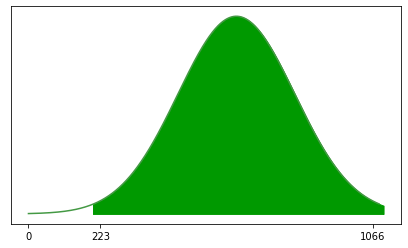

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(7,4))
x1 = np.linspace(0,6*scale,1000)
x2 = np.linspace(200,1100,1000)
ax1.plot(x1,stats.norm.pdf(x1,loc=loc,scale=scale),color="#449944")
ax1.fill_between(x2,stats.norm.pdf(x2,loc=loc,scale=scale),0,color="#009900")
ax1.set_yticks([])
ax1.set_xticks([0,223,1066])
plt.show()

<h3>Prior predictive distribution</h3>

The goal of this part was to simulate possible parameters based just on the prior info. I've created another stan file to generate model and extract parameters.

In [9]:
with open('Tune_4_1_2.stan','r') as file:
    print(file.read())

data {
  int Years;
}

generated quantities {
  real lambda = normal_rng(644,181);
  int y_sim[Years];
  for (i in 1:Years) {
    y_sim[i] = poisson_rng(lambda);
  }
}


In [10]:
model = pystan.StanModel('Tune_4_1_2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8bcf9732782a30f5efd081bac8f646f7 NOW.


In [11]:
data_tuned = model.sampling(data={'Years':1}, algorithm="Fixed_param",iter=500, warmup=0, chains=1,seed=1052020)

lam = data_tuned.extract()['lambda']
y_sim = data_tuned.extract()['y_sim']

I've ploted the result below. Estimation is far from ideal, but it could be expected - creating accurate prior is very difficult.

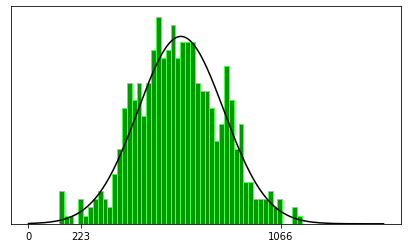

In [12]:
fig, ax2 = plt.subplots(1,1,figsize=(7,4))

ax2.hist(lam,bins=50,color="#009900",edgecolor="#44FF44",density=True)
x = np.linspace(0,1500,2000)
ax2.set_xticks([0,223,1066])
ax2.set_yticks([])
ax2.plot(x,stats.norm.pdf(x,loc,scale),color='black', linestyle='-')

plt.show()

<h3>Posterior interference and posterior predictive checks</h3>

Another time, I've used stan file to get the neccessary info from the stan model.

In [13]:
with open('Tune_4_1_3.stan','r') as file:
    print(file.read())

data {
  int Years;
  int Deaths[Years];
}
parameters {
  real<lower=0> lambda;
}
model {
  lambda ~ normal(644,181);
  for (i in 1:Years) {
    Deaths[i] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[Years];
  for (i in 1:Years) {
    y_sim[i] = poisson_rng(lambda);
  }
}


In [14]:
model = pystan.StanModel('Tune_4_1_3.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92775d8e4a1ba7db0ed0fb4e182aee79 NOW.


In [15]:
data = dict(Years = len(df), Deaths = df['Passenger deaths'])
data_tuned = model.sampling(data=data, seed=1052020)

lam = data_tuned.extract()['lambda']
y_sim = data_tuned.extract()['y_sim']

I've calculated the mean of posterior intrefrence along with 90% confidence interval limit values.

In [16]:
mean_lambda = np.mean(lam)
cinf_lambda = az.hpd(lam,0.9)

hpd_width= cinf_lambda[1]-cinf_lambda[0]

In [17]:
print("Mean lambda:\t" + str(mean_lambda))
print("90% conf. interval:\t[" + str(cinf_lambda[0]) + '\t'+ str(cinf_lambda[1]) + ']')

Mean lambda:	692.0416166194061
90% conf. interval:	[679.2454280192097	706.1549302421664]


I've created a histogram presetnig the lambda value changes, also marking the 90% conf. interval, which I've calculated before.

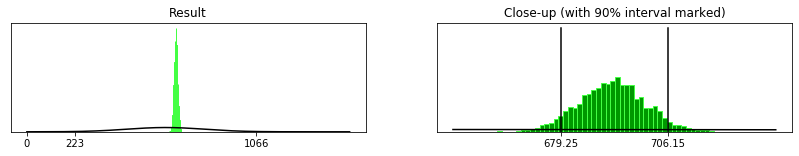

In [23]:
fig, ax = plt.subplots(1,2, figsize=(14,2))

x = np.linspace(0,1500,1000)

ax[0].hist(lam, bins=50, color="#009900", edgecolor="#44FF44", density=True)
ax[0].plot(x,stats.norm.pdf(x,loc,scale), color='black')
ax[0].set_xticks([0,223,1066])
ax[0].set_yticks([])
ax[0].set_title('Result')

x = np.linspace(cinf_lambda[0]-hpd_width,cinf_lambda[1]+hpd_width,1000)

ax[1].hist(lam, bins=50, color="#009900", edgecolor="#44FF44", density=True)
ax[1].plot(x,stats.norm.pdf(x,loc,scale), color='black')
ax[1].plot([cinf_lambda[0],cinf_lambda[0]],[0,0.1],color='black')
ax[1].plot([cinf_lambda[1],cinf_lambda[1]],[0,0.1],color='black')
ax[1].set_xticks(cinf_lambda[0:2])
ax[1].set_yticks([])
ax[1].set_title('Close-up (with 90% interval marked)')

plt.show()

Then, I tried to predict daeth rate from the newest model:

In [24]:
predict_mean = np.median(y_sim.flatten())
predict_interval = az.hpd(y_sim.flatten(), 0.99)
print('Mean (predicted number of accidents):\t' + str(predict_mean))
print("Interval:\t[" + str(predict_interval[0]) + '\t' + str(predict_interval[1]) + ']')

Mean (predicted number of accidents):	692.0
Interval:	[621.0	762.0]


The actual number of deaths in 1986 was 546, so the result I've got from the created model isn't correct.

The reason is probably the fact, that I've created the model only based on number of deaths over the years. The rest of columns in given dataframe (distance flown, count of flights, etc.) also affects the value in the real world, so consideration of those might be crucial.

On the other hand, I'm happy that in this case I've faced an overgrowth ;)

<h1>Exrecise 2</h1>

This time the intensity is constant, and the rate is a product of intensity and miles, so the Poisson distribution is needed once again.

In [25]:
intensity = np.mean(df['Death rate'])
intensity

0.126

In [26]:
min_limit = 223/intensity
max_limit = 1066/intensity

I've used the model from the first part of the first exercise.

In [27]:
model = pystan.StanModel('Tune_4_1_1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a150d842f36d5ed84746f1777fd72d1f NOW.


In [28]:
data = dict(y_guess=np.array([6700,2000]), theta=np.array([max_limit, min_limit]))

data_tuned = model.sampling(data=data, seed=1052020, algorithm = "Fixed_param", iter=1, warmup=0, chains=1)

loc = np.round(data_tuned.extract()['loc'][0])
scale = np.round(data_tuned.extract()['scale'][0])

print(loc, scale)

5115.0 1438.0


I've drawn a plot showing the Poisson distribution in this case.

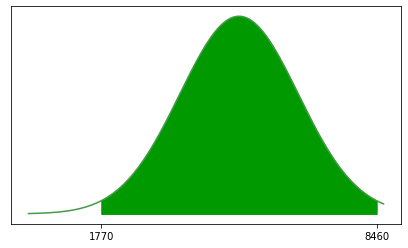

In [29]:
fig, ax4 = plt.subplots(1,1,figsize=(7,4))
x1 = np.linspace(0,6*scale,1000)
x2 = np.linspace(min_limit,max_limit,1000)

ax4.plot(x1,stats.norm.pdf(x1,loc=loc,scale=scale),color="#449944")
ax4.fill_between(x2,stats.norm.pdf(x2,loc=loc,scale=scale),0,color="#009900")
ax4.set_yticks([])
ax4.set_xticks([min_limit, max_limit])
plt.show()

<h3>Prior predictive distribution</h3>

Another time, I've used it to simulated parameters based just on prior info.

In [30]:
with open('Tune_4_2_1.stan','r') as file:
    print(file.read())

data {
  int Y;
  vector<lower=0>[Y] death_rate
}

generated quantities {
  real lambda = normal_rng(5115,1438);
  int y_sim[Y];
  for (i in 1:Y) {
    y_sim[i] = poisson_rng(lambda*death_rate[i]);
  }
}


In [32]:
model = pystan.StanModel('Tune_4_2_1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9175a9312f4425810ce180e93843295d NOW.


I've used generated model to extract generated output parameters.

In [33]:
data = dict(Y=len(df), death_rate=df['Death rate'].to_numpy())

data_tuned = model.sampling(data=data, algorithm="Fixed_param",iter=500, warmup=0, chains=1,seed=1052020)

lam = data_tuned.extract()['lambda']
y_sim = data_tuned.extract()['y_sim']

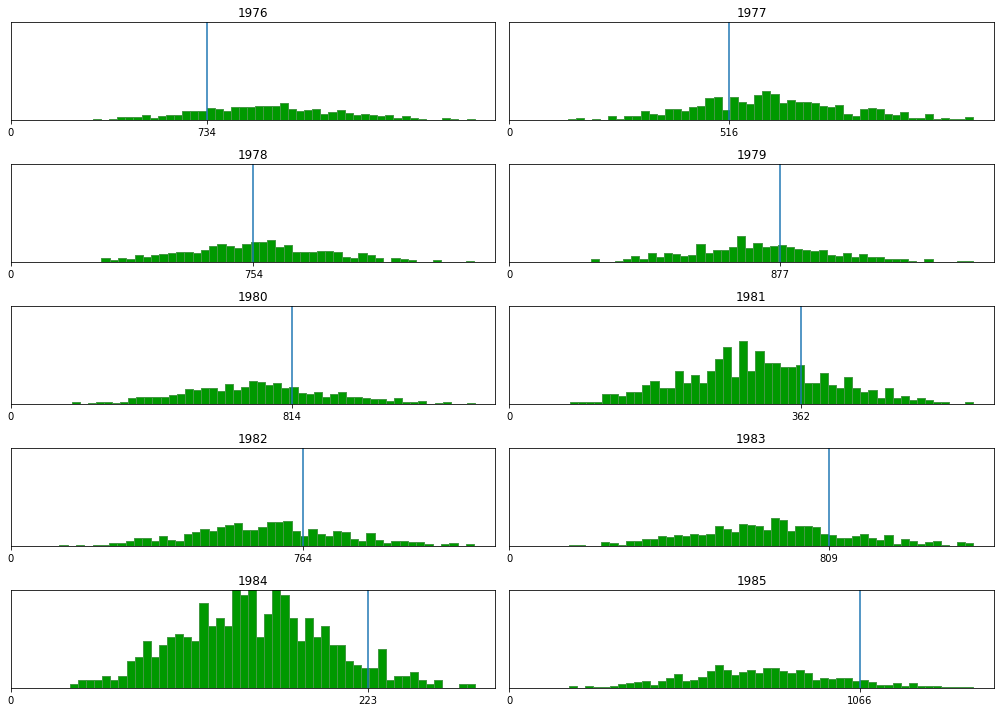

In [35]:
fig, axes = plt.subplots(5,2,figsize=(14,10), squeeze=False, sharey=True)
axes = axes.flatten()

for i in range(len(axes)):
    ax = axes[i]
    ax.hist(y_sim[:,i], bins=50,color="#009900", edgecolor= "#449944", density=True)
    ax.set_title(df['Year'][i])
    true_val = df['Passenger deaths'].iloc[i]
    ax.plot([true_val,true_val],[0,0.01])
    ax.set_yticks([])
    ax.set_xticks([0, true_val])
    ax.set_ylim([0,0.01])

fig.tight_layout()
plt.show()

<h3>Posterior interference nd posterior predictive checks</h3>

I've created stan file, with is presented below, to go through analogic simulation as in exercise 1.

In [36]:
with open('Tune_4_2_2.stan','r') as file:
    print(file.read())

data {
  int Years;
  int Deaths[Years];
  vector[Years] death_rate;
}
parameters {
  real<lower=0> lambda;
}
model {
  lambda ~ normal(5115,1438);
  for (i in 1:Years) {
    Deaths[i] ~ poisson(death_rate[i]*lambda);
  }
}
generated quantities {
  int y_sim[Years];
  for (i in 1:Years) {
    y_sim[i] = poisson_rng(death_rate[i]*lambda);
  }
}


In [37]:
model = pystan.StanModel('Tune_4_2_2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd3e7cd675db05f5ee2ed19cabee1980 NOW.


In [38]:
data = dict(Years = len(df), Deaths = df['Passenger deaths'], death_rate = df['Death rate'].to_numpy())
data_tuned = model.sampling(data=data, seed=1052020)

The mean I've calculated from extracted data (along with 90% conf. interval):

In [39]:
lam = data_tuned.extract()['lambda']
y_sim = data_tuned.extract()['y_sim']

In [40]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.9)
hpd_width = cinf_lam[1] - cinf_lam[0]

In [41]:
print("Mean lambda:\t" + str(mean_lambda))
print("90% conf. interval:\t[" + str(cinf_lambda[0]) + '\t'+ str(cinf_lambda[1]) + ']')

Mean lambda:	692.0416166194061
90% conf. interval:	[679.2454280192097	706.1549302421664]


Here's are the histograms presenting changes of the lambda value in each year, with marked ticks of actual value:

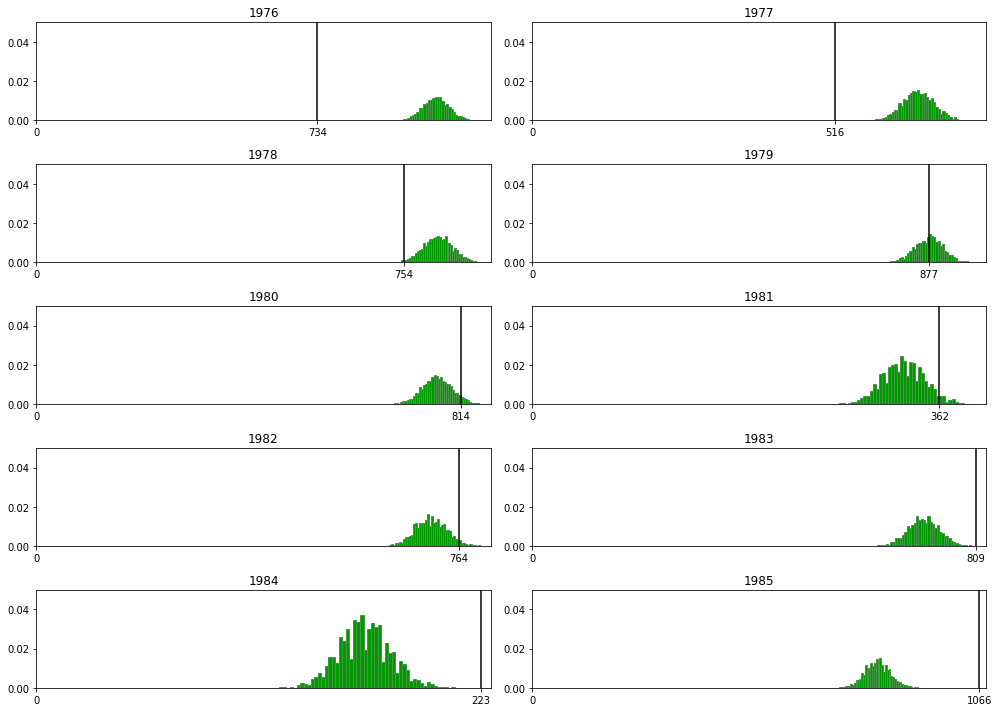

In [44]:
fig, axes = plt.subplots(5,2,figsize=(14,10), squeeze=False, sharey=False)
axes = axes.flatten()

for i in range(len(axes)):
    ax = axes[i]
    ax.hist(y_sim[:,i], bins=50,color="#009900",edgecolor="#449944", density=True)
    ax.set_title(df['Year'][i])
    true_val = df['Passenger deaths'].iloc[i]
    ax.plot([true_val,true_val],[0,0.05], color='black')
    ax.set_xticks([0, true_val])
    ax.set_ylim([0,0.05])

fig.tight_layout()

plt.show()

<h3>Prediction </h3>

The real number of passenger deaths in 1986 was 546. There were 22 fatal accidents, so the death rate in this year was 0.06 (per 100 mln miles flown).

With all this data gathered, I've used the stan file attached below to generate final model for this exercise:

In [45]:
with open('Tune_4_2_3.stan','r') as file:
    print(file.read())

data {
  int Years;
  int Deaths[Years];
  vector[Years] death_rate;
}
parameters {
  real<lower=0> lambda;
}
model {
  lambda ~ normal(5115,1438);
  for (i in 1:Years) {
    Deaths[i] ~ poisson(death_rate[i]*lambda);
  }
}
generated quantities {
  int y_1986 = poisson_rng(0.06*lambda);
}


In [46]:
model = pystan.StanModel('Tune_4_2_3.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2022f101a98159f7317e8321f982a9d2 NOW.


I didn't need to change the data dictionary, so I used the previous one once again.

I've also used 99% confidence interval in this case.

In [47]:
result = model.sampling(data=data)

lam = result.extract()['lambda']
y_1986 = result.extract()['y_1986']

median_1986 = np.median(y_1986)
interval_1986 = az.hpd(y_1986, 0.99)

In [49]:
print("Median lambda:\t" + str(median_1986))
print("99% conf. interval:\t[" + str(interval_1986[0]) + '\t'+ str(interval_1986[1]) + ']')

Median lambda:	329.0
99% conf. interval:	[287.0	375.0]


The result - predicted distribution histogram - is presented below:

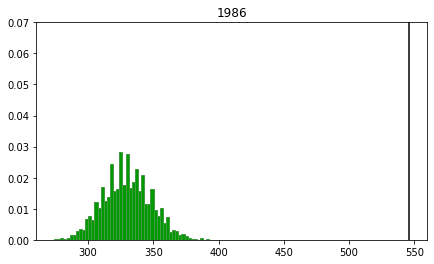

In [52]:
fig, ax5 = plt.subplots(1,1,figsize=(7,4))
ax5.hist(y_1986, bins=50,color="#009900",edgecolor="#449944",density=True)
ax5.set_title('1986')
ax5.plot([546,546],[0,0.07],color='black')
ax5.set_ylim([0,0.07])

plt.show()

Predicted value of deaths is this time much lower, than the real value. It is the fault of low death rate, which I took as main reference in prediction. The accurate value isn't even in the 99% interval.

<h3>Conclusions:</h3>

Stan is a very useful tool in such kind of predictions. Lack of accuraccy might be a fault of amount of data we have to work with - it is always better to work with as much accurate data as possible. Another reason might be my lack of expertise, but after completing this exercise my experience with prediction surely has grown.